In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

In [2]:
# ---------------------------------------------------------------------
# Data loading helper
# ---------------------------------------------------------------------
import numpy as np
from typing import Callable, Optional, Tuple
Array = np.ndarray

def load_data_from_npz(path: str) -> Tuple[Array, Array, dict]:
    """Load latent states X and observations Y from .npz file."""
    data = np.load(path)
    if "X" not in data.files or "Y" not in data.files:
        raise ValueError(f"File '{path}' must contain 'X' and 'Y'.")
    X, Y = data["X"], data["Y"]
    params = {k: data[k] for k in data.files if k not in ("X", "Y")}
    print(f"Loaded {path}: X.shape={X.shape}, Y.shape={Y.shape}")
    return X, Y, params

In [3]:

# ---------------------------------------------------------------------
# Load data
# ---------------------------------------------------------------------
"""Example: Particle Filter on stochastic volatility data."""
npz_path = "../simulator/data/sv_simul_data.npz"
X_true, Y_obs, params = load_data_from_npz(npz_path)

Loaded ../simulator/data/sv_simul_data.npz: X.shape=(2000,), Y.shape=(2000,)


In [4]:
# Import the Particle Filter class
from models.particle_filter import ParticleFilter, PFState
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# Standard Particle Filter on Stochastic Volatility Model
# ---------------------------------------------------------------
print("=" * 70)
print("STANDARD PARTICLE FILTER (on SV model)")
print("=" * 70)

# Load the same data used in EKF/UKF experiments
X_true_flat = X_true.flatten()
Y_obs_flat = Y_obs.flatten()

# Model parameters (same as EKF/UKF)
# Extract scalar values from params (they might be arrays)
alpha_param = params.get("alpha", 0.91)
alpha_true = float(alpha_param) if np.ndim(alpha_param) == 0 else float(alpha_param.flatten()[0])

beta_param = params.get("beta", 0.5)
# Handle beta as array - take first element if it's an array
if isinstance(beta_param, np.ndarray):
    beta_true = float(beta_param.flatten()[0])
else:
    beta_true = float(beta_param)

sigma_true = 1.0  # State noise std (from Q)

dx = 1  # State dimension 
dy = 1  # Observation dimension 
n = len(Y_obs_flat)

print(f"\nData loaded: n={n}, dx={dx}, dy={dy}")
print(f"True parameters: alpha={alpha_true}, sigma={sigma_true}, beta={beta_true}")

# ---------------------------------------------------------------
# Define model functions for PF
# ---------------------------------------------------------------
def g_pf(x: np.ndarray, u: Optional[np.ndarray] = None) -> np.ndarray:
    """State transition: X_t = alpha * X_{t-1} + w_t."""
    x = np.atleast_1d(x)
    return alpha_true * x

def h_pf(x: np.ndarray) -> np.ndarray:
    """Observation model: Y_t = beta * exp(0.5 * X_t) * W_t.
    
    Note: PF can handle multiplicative noise properly.
    The observation function just returns the mean.
    """
    x = np.atleast_1d(x)
    return beta_true * np.exp(0.5 * x)

# Process noise covariance
Q_pf = np.array([[sigma_true**2]])

# Measurement noise covariance (constant assumption - same as standard EKF/UKF)
R_pf = np.array([[beta_true**2]])

print(f"\nParticle Filter Setup:")
print(f"  Number of particles: Np = 1000")
print(f"  Q = {Q_pf[0,0]:.4f} (process noise variance)")
print(f"  R = {R_pf[0,0]:.4f} (measurement noise variance)")
print(f"  Resampling threshold: 0.5 (resample when Neff < 0.5*Np)")

# Create PF instance
pf = ParticleFilter(
    g=g_pf,
    h=h_pf,
    Q=Q_pf,
    R=R_pf,
    Np=1000,                          # Number of particles
    resample_thresh=0.5,              # Resample when Neff < 50% of Np
    regularize_after_resample=True    # Add small jitter after resampling
)

# ---------------------------------------------------------------
# Initialize state
# ---------------------------------------------------------------
# Initial state: use prior distribution
x0_pf = np.array([0.0])  # Prior mean
P0_pf = np.array([[sigma_true**2 / (1 - alpha_true**2)]])  # Stationary variance

# Initialize particles
pf.initialize(mean=x0_pf, cov=P0_pf)

print(f"\nInitial state:")
print(f"  x0 = {x0_pf[0]:.4f}")
print(f"  P0 = {P0_pf[0,0]:.4f}")
print(f"  Initial particles shape: {pf.state.particles.shape}")

# ---------------------------------------------------------------
# Sequential PF filtering
# ---------------------------------------------------------------
est_X_pf = np.zeros(n)
est_P_pf = np.zeros(n)
neff_history = np.zeros(n)

# First update (t=0)
state_pf = pf.update(Y_obs_flat[0].reshape(1))
est_X_pf[0] = state_pf.mean[0]
est_P_pf[0] = state_pf.cov[0, 0]
neff_history[0] = pf.effective_sample_size()

print(f"\nRunning standard PF filtering...")

for k in range(1, n):
    # PF predict step
    pf.predict()
    
    # PF update step
    state_pf = pf.update(Y_obs_flat[k].reshape(1))
    
    # Store estimates
    est_X_pf[k] = state_pf.mean[0]
    est_P_pf[k] = state_pf.cov[0, 0]
    neff_history[k] = pf.effective_sample_size()
    
    # Progress indicator
    if (k+1) % 400 == 0:
        print(f"  t={k+1}/{n}, Neff={neff_history[k]:.1f}, mean={est_X_pf[k]:.3f}")

print("✓ PF filtering complete!")
print(f"\nFinal state estimates:")
print(f"  Mean: {state_pf.mean[0]:.4f}")
print(f"  Variance: {state_pf.cov[0,0]:.4f}")
print(f"  True final X: {X_true_flat[-1]:.4f}")
print(f"  Final Neff: {neff_history[-1]:.1f} / {pf.Np}")

# ---------------------------------------------------------------
# Compute RMSE
# ---------------------------------------------------------------
rmse_pf = np.sqrt(np.mean((est_X_pf - X_true_flat)**2))

print(f"\n" + "=" * 70)
print("STANDARD PARTICLE FILTER PERFORMANCE")
print("=" * 70)
print(f"RMSE: {rmse_pf:.4f}")
print(f"Mean Neff: {np.mean(neff_history):.1f}")
print(f"Min Neff: {np.min(neff_history):.1f}")
print(f"Resampling rate: {np.sum(neff_history < 0.5 * pf.Np) / n * 100:.1f}%")
print("=" * 70)

STANDARD PARTICLE FILTER (on SV model)

Data loaded: n=2000, dx=1, dy=1
True parameters: alpha=0.91, sigma=1.0, beta=0.5

Particle Filter Setup:
  Number of particles: Np = 1000
  Q = 1.0000 (process noise variance)
  R = 0.2500 (measurement noise variance)
  Resampling threshold: 0.5 (resample when Neff < 0.5*Np)

Initial state:
  x0 = 0.0000
  P0 = 5.8173
  Initial particles shape: (1000, 1)

Running standard PF filtering...
  t=400/2000, Neff=1000.0, mean=-2.768
  t=800/2000, Neff=716.2, mean=-2.402
  t=1200/2000, Neff=543.6, mean=-2.163
  t=1600/2000, Neff=763.6, mean=-2.813
  t=2000/2000, Neff=1000.0, mean=-3.240
✓ PF filtering complete!

Final state estimates:
  Mean: -3.2400
  Variance: 2.9303
  True final X: 0.1598
  Final Neff: 1000.0 / 1000

STANDARD PARTICLE FILTER PERFORMANCE
RMSE: 3.4373
Mean Neff: 808.3
Min Neff: 500.1
Resampling rate: 0.0%


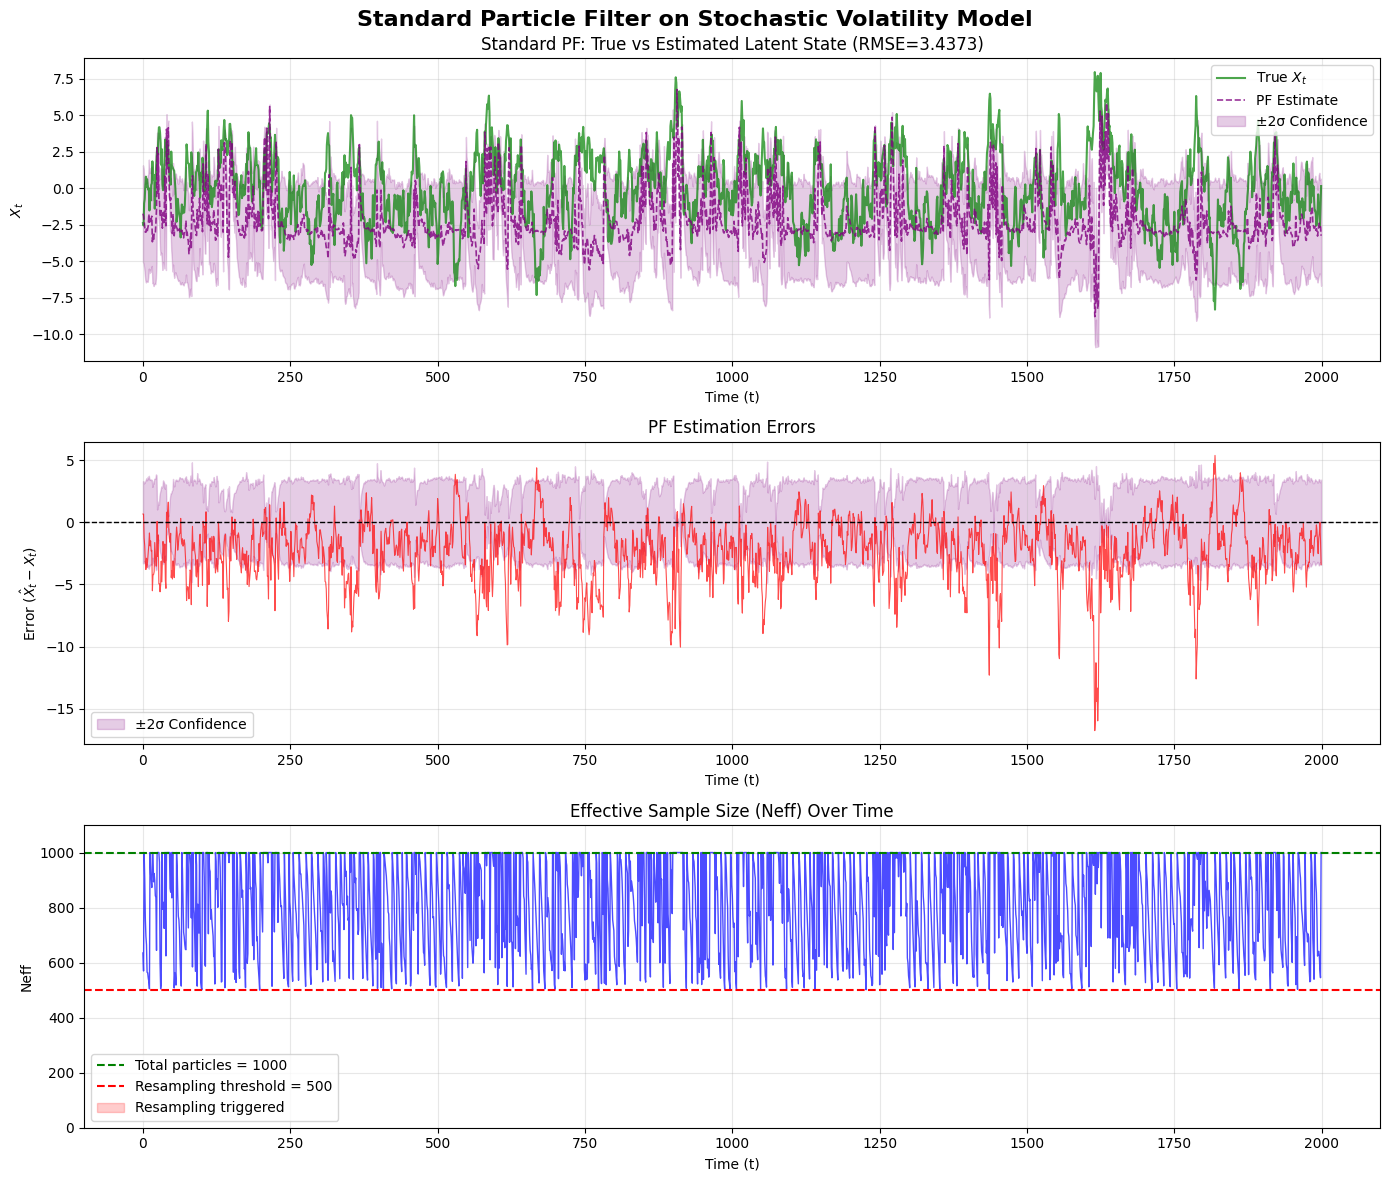


Calibration Check (95% Coverage):
  Standard PF: 64.8% (should be ~95%)

Error Statistics:
  Mean error:  -2.3459
  Std error:   2.5123
  Max |error|: 16.7460

PARTICLE DEGENERACY STATISTICS
Mean $N_{eff}$: 808.3 / 1000
Min $N_{eff}$: 500.1 / 1000
Max $N_{eff}$: 1000.0 / 1000

Degeneracy frequency:
  Severe (Neff < 0.1*Np):   0.0% of time
  Moderate (Neff < 0.5*Np): 0.0% of time
  Good (Neff > 0.5*Np):     100.0% of time

Average degeneracy level: 19.2%


In [5]:
# ---------------------------------------------------------------
# Visualization: PF results 
# ---------------------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('Standard Particle Filter on Stochastic Volatility Model', fontsize=16, fontweight='bold')

# Plot 1: True vs PF estimate with confidence intervals
axes[0].plot(X_true_flat, linewidth=1.5, label='True $X_t$', color='green', alpha=0.7)
axes[0].plot(est_X_pf, linewidth=1.2, label='PF Estimate', color='purple', linestyle='--', alpha=0.8)
axes[0].fill_between(range(n), 
                      est_X_pf - 2*np.sqrt(est_P_pf), 
                      est_X_pf + 2*np.sqrt(est_P_pf),
                      alpha=0.2, color='purple', label='±2σ Confidence')
axes[0].set_title(f'Standard PF: True vs Estimated Latent State (RMSE={rmse_pf:.4f})')
axes[0].set_xlabel('Time (t)')
axes[0].set_ylabel('$X_t$')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Estimation errors
errors_pf = est_X_pf - X_true_flat
axes[1].plot(errors_pf, linewidth=0.8, alpha=0.7, color='red')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].fill_between(range(n), -2*np.sqrt(est_P_pf), 2*np.sqrt(est_P_pf),
                     alpha=0.2, color='purple', label='±2σ Confidence')
axes[1].set_title('PF Estimation Errors')
axes[1].set_xlabel('Time (t)')
axes[1].set_ylabel('Error ($\\hat{X}_t - X_t$)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Effective sample size (Neff) over time
axes[2].plot(neff_history, linewidth=1.0, color='blue', alpha=0.7)
axes[2].axhline(pf.Np, color='green', linestyle='--', linewidth=1.5, 
                label=f'Total particles = {pf.Np}')
axes[2].axhline(0.5 * pf.Np, color='red', linestyle='--', linewidth=1.5, 
                label=f'Resampling threshold = {0.5*pf.Np:.0f}')
axes[2].fill_between(range(n), 0, pf.Np, where=(neff_history < 0.5*pf.Np), 
                     alpha=0.2, color='red', label='Resampling triggered')
axes[2].set_title('Effective Sample Size (Neff) Over Time')
axes[2].set_xlabel('Time (t)')
axes[2].set_ylabel('Neff')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, pf.Np * 1.1])


plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# Diagnostics
# ---------------------------------------------------------------
# Compute 95% coverage (calibration check)
std_pf = np.sqrt(est_P_pf)
inside_95_pf = np.abs(errors_pf) <= 1.96 * std_pf
coverage_pf = np.mean(inside_95_pf) * 100

print(f"\nCalibration Check (95% Coverage):")
print(f"  Standard PF: {coverage_pf:.1f}% (should be ~95%)")

# Show error statistics
print(f"\nError Statistics:")
print(f"  Mean error:  {np.mean(errors_pf):.4f}")
print(f"  Std error:   {np.std(errors_pf):.4f}")
print(f"  Max |error|: {np.max(np.abs(errors_pf)):.4f}")

# Summary statistics
print(f"\nPARTICLE DEGENERACY STATISTICS")
print(f"{'='*70}")
print(f"Mean $N_{{eff}}$: {np.mean(neff_history):.1f} / {pf.Np}")
print(f"Min $N_{{eff}}$: {np.min(neff_history):.1f} / {pf.Np}")
print(f"Max $N_{{eff}}$: {np.max(neff_history):.1f} / {pf.Np}")
print(f"\nDegeneracy frequency:")
print(f"  Severe (Neff < 0.1*Np):   {np.sum(neff_history < 0.1*pf.Np) / n * 100:.1f}% of time")
print(f"  Moderate (Neff < 0.5*Np): {np.sum(neff_history < 0.5*pf.Np) / n * 100:.1f}% of time")
print(f"  Good (Neff > 0.5*Np):     {np.sum(neff_history >= 0.5*pf.Np) / n * 100:.1f}% of time")
print(f"\nAverage degeneracy level: {(1 - np.mean(neff_history)/pf.Np) * 100:.1f}%")

## Particle Filter with Log-Squared Transformation

The standard SV model has:
- State: $X_t = \alpha X_{t-1} + \sigma W_t$
- Observation: $Y_t = \beta \exp(0.5 X_t) \cdot V_t$, where $V_t \sim \mathcal{N}(0, 1)$

This creates a **multiplicative noise** problem where the likelihood is highly peaked and numerically unstable.

### Log-Squared Transformation

Transform observations: $Z_t = \log Y_t^2$

Then:
$$Z_t = \log(\beta^2) + X_t + \log(V_t^2)$$

where $\log(V_t^2) \sim \text{LogChiSquare}(1)$ has:
- Mean: $\mathbb{E}[\log V_t^2] = \psi(1/2) - \log(1/2) \approx -1.2704$ (digamma function)
- Variance: $\text{Var}[\log V_t^2] = \psi'(1/2) = \pi^2/2 \approx 4.9348$ (trigamma function)

### Advantages:
1. **Additive noise model** - easier for particle filter
2. **Better numerical stability** - no exp() in likelihood
3. **More Gaussian-like** - log transformation makes distribution more symmetric
4. **Information preserved** - $Y_t^2$ contains all info about $X_t$

In [6]:
import scipy.special as sp

# ---------------------------------------------------------------
# Log-Squared Transformation PF Setup
# ---------------------------------------------------------------
print("=" * 70)
print("PARTICLE FILTER WITH LOG-SQUARED TRANSFORMATION")
print("=" * 70)

# Transform observations: Z_t = log(Y_t^2)
Z_obs = np.log(Y_obs_flat**2)

print(f"\nTransformed observations:")
print(f"  Original Y shape: {Y_obs_flat.shape}")
print(f"  Transformed Z = log(Y²) shape: {Z_obs.shape}")
print(f"  Z range: [{np.min(Z_obs):.2f}, {np.max(Z_obs):.2f}]")

# Log-ChiSquare(1) noise statistics
# For V ~ N(0,1), log(V^2) has known moments
psi_half = sp.digamma(0.5)  # Phi(1/2) ≈ -1.9635
log_half = np.log(0.5)       # log(1/2) ≈ -0.6931
epsilon_mean = psi_half - log_half  # ≈ -1.2704
epsilon_var = sp.polygamma(1, 0.5)   # Phi'(1/2) = pi^2/2 ≈ 4.9348

print(f"\nLog-ChiSquare(1) noise parameters:")
print(f"  E[log(V²)] = ψ(1/2) - log(1/2) = {epsilon_mean:.4f}")
print(f"  Var[log(V²)] = ψ'(1/2) = π²/2 = {epsilon_var:.4f}")

# Model in transformed space:
# X_t = alpha * X_{t-1} + w_t,  w_t ~ N(0, sigma^2)
# Z_t = log(beta^2) + X_t + epsilon_t,  epsilon_t ~ LogChiSq(1)
# For PF we approximate: Z_t ≈ log(beta^2) + X_t + N(epsilon_mean, epsilon_var)

log_beta_sq = np.log(beta_true**2)

print(f"\nModel in transformed space:")
print(f"  State: X_t = {alpha_true:.2f} * X_{{t-1}} + N(0, {sigma_true**2:.2f})")
print(f"  Observation: Z_t = {log_beta_sq:.4f} + X_t + N({epsilon_mean:.4f}, {epsilon_var:.4f})")

# ---------------------------------------------------------------
# Define PF functions in transformed space
# ---------------------------------------------------------------
def g_log(x: np.ndarray, u: Optional[np.ndarray] = None) -> np.ndarray:
    """State transition."""
    x = np.atleast_1d(x)
    return alpha_true * x

def h_log(x: np.ndarray) -> np.ndarray:
    """Observation model in log-squared space: Z_t = log(beta^2) + X_t + noise_mean."""
    x = np.atleast_1d(x)
    return log_beta_sq + x + epsilon_mean

# Process noise 
Q_log = np.array([[sigma_true**2]])

# Observation noise in transformed space
# Use the variance of log(V^2)
R_log = np.array([[epsilon_var]])

print(f"\nParticle Filter Setup (Log-Squared Space):")
print(f"  Q = {Q_log[0,0]:.4f} (process noise variance)")
print(f"  R = {R_log[0,0]:.4f} (observation noise variance in log-space)")
print(f"  Number of particles: Np = 1000")

# Create PF instance
pf_log = ParticleFilter(
    g=g_log,
    h=h_log,
    Q=Q_log,
    R=R_log,
    Np=1000,
    resample_thresh=0.5,
    regularize_after_resample=True
)

# Initialize
pf_log.initialize(mean=x0_pf, cov=P0_pf)

print(f"\n✓ PF-LogSq initialized with {pf_log.Np} particles")

PARTICLE FILTER WITH LOG-SQUARED TRANSFORMATION

Transformed observations:
  Original Y shape: (2000,)
  Transformed Z = log(Y²) shape: (2000,)
  Z range: [-18.38, 8.72]

Log-ChiSquare(1) noise parameters:
  E[log(V²)] = ψ(1/2) - log(1/2) = -1.2704
  Var[log(V²)] = ψ'(1/2) = π²/2 = 4.9348

Model in transformed space:
  State: X_t = 0.91 * X_{t-1} + N(0, 1.00)
  Observation: Z_t = -1.3863 + X_t + N(-1.2704, 4.9348)

Particle Filter Setup (Log-Squared Space):
  Q = 1.0000 (process noise variance)
  R = 4.9348 (observation noise variance in log-space)
  Number of particles: Np = 1000

✓ PF-LogSq initialized with 1000 particles


In [7]:
# ---------------------------------------------------------------
# Run PF-LogSq filtering
# ---------------------------------------------------------------
import time
est_X_log = np.zeros(n)
est_P_log = np.zeros(n)
neff_history_log = np.zeros(n)

print(f"\nRunning PF-LogSq filtering on {n} time steps...")
start_time = time.time()

# First update (t=0)
state_log = pf_log.update(Z_obs[0].reshape(1))
est_X_log[0] = state_log.mean[0]
est_P_log[0] = state_log.cov[0, 0]
neff_history_log[0] = pf_log.effective_sample_size()

# Sequential filtering
for k in range(1, n):
    pf_log.predict()
    state_log = pf_log.update(Z_obs[k].reshape(1))
    
    est_X_log[k] = state_log.mean[0]
    est_P_log[k] = state_log.cov[0, 0]
    neff_history_log[k] = pf_log.effective_sample_size()
    
    if (k+1) % 400 == 0:
        print(f"  t={k+1}/{n}, Neff={neff_history_log[k]:.1f}, mean={est_X_log[k]:.3f}")

log_time = time.time() - start_time

print("✓ PF-LogSq filtering complete!")
print(f"\nFinal state estimates:")
print(f"  Mean: {state_log.mean[0]:.4f}")
print(f"  Variance: {state_log.cov[0,0]:.4f}")
print(f"  True final X: {X_true_flat[-1]:.4f}")
print(f"  Final Neff: {neff_history_log[-1]:.1f} / {pf_log.Np}")

# ---------------------------------------------------------------
# Compute performance metrics
# ---------------------------------------------------------------
rmse_log = np.sqrt(np.mean((est_X_log - X_true_flat)**2))
errors_log = est_X_log - X_true_flat
std_log = np.sqrt(est_P_log)
inside_95_log = np.abs(errors_log) <= 1.96 * std_log
coverage_log = np.mean(inside_95_log) * 100

print(f"\n" + "=" * 70)
print("PF-LOGSQ PERFORMANCE")
print("=" * 70)
print(f"RMSE: {rmse_log:.4f}")
print(f"Mean Neff: {np.mean(neff_history_log):.1f}")
print(f"Min Neff: {np.min(neff_history_log):.1f}")
print(f"Resampling rate: {np.sum(neff_history_log < 0.5 * pf_log.Np) / n * 100:.1f}%")
print(f"95% Coverage: {coverage_log:.1f}%")
print(f"Computation time: {log_time:.2f}s")
print("=" * 70)


Running PF-LogSq filtering on 2000 time steps...
  t=400/2000, Neff=593.1, mean=0.415
  t=800/2000, Neff=1000.0, mean=-1.659
  t=1200/2000, Neff=576.0, mean=-0.522
  t=1600/2000, Neff=754.2, mean=-0.208
  t=2000/2000, Neff=725.5, mean=0.315
✓ PF-LogSq filtering complete!

Final state estimates:
  Mean: 0.3149
  Variance: 1.7318
  True final X: 0.1598
  Final Neff: 725.5 / 1000

PF-LOGSQ PERFORMANCE
RMSE: 1.2504
Mean Neff: 794.0
Min Neff: 500.1
Resampling rate: 0.0%
95% Coverage: 95.0%
Computation time: 4.98s


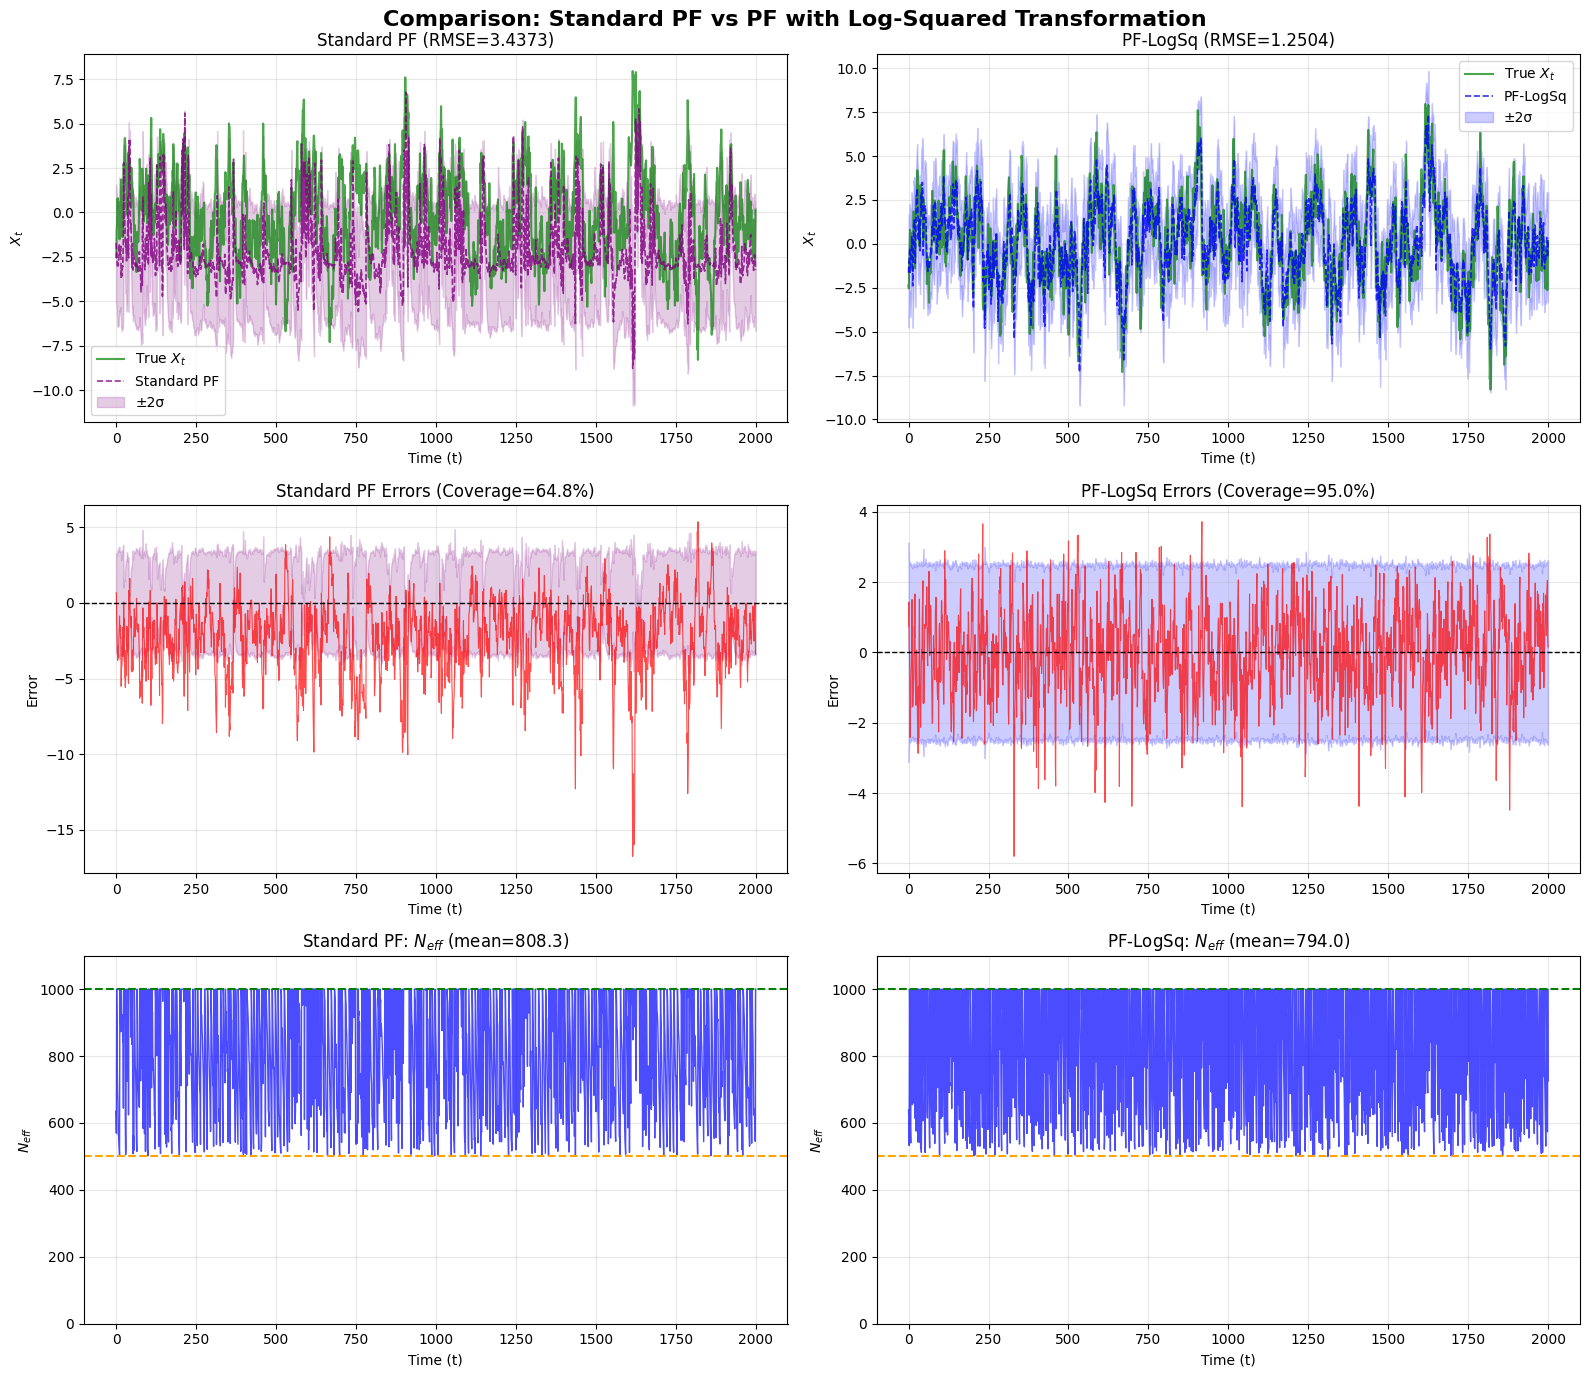

In [8]:
# ---------------------------------------------------------------
# Comparison: Standard PF vs PF-LogSq
# ---------------------------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('Comparison: Standard PF vs PF with Log-Squared Transformation', 
             fontsize=16, fontweight='bold')

# ============================================================
# LEFT COLUMN: Standard PF
# ============================================================

# Plot 1: State estimates
axes[0, 0].plot(X_true_flat, linewidth=1.5, label='True $X_t$', color='green', alpha=0.7)
axes[0, 0].plot(est_X_pf, linewidth=1.2, label='Standard PF', color='purple', linestyle='--', alpha=0.8)
axes[0, 0].fill_between(range(n), 
                        est_X_pf - 2*np.sqrt(est_P_pf), 
                        est_X_pf + 2*np.sqrt(est_P_pf),
                        alpha=0.2, color='purple', label='±2σ')
axes[0, 0].set_title(f'Standard PF (RMSE={rmse_pf:.4f})')
axes[0, 0].set_xlabel('Time (t)')
axes[0, 0].set_ylabel('$X_t$')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Estimation errors
axes[1, 0].plot(errors_pf, linewidth=0.8, alpha=0.7, color='red')
axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1, 0].fill_between(range(n), -2*std_pf, 2*std_pf,
                        alpha=0.2, color='purple')
axes[1, 0].set_title(f'Standard PF Errors (Coverage={coverage_pf:.1f}%)')
axes[1, 0].set_xlabel('Time (t)')
axes[1, 0].set_ylabel('Error')
axes[1, 0].grid(True, alpha=0.3)

# Plot 3: Neff
axes[2, 0].plot(neff_history, linewidth=1.0, color='blue', alpha=0.7)
axes[2, 0].axhline(pf.Np, color='green', linestyle='--', linewidth=1.5)
axes[2, 0].axhline(0.5 * pf.Np, color='orange', linestyle='--', linewidth=1.5)
axes[2, 0].set_title(f'Standard PF: $N_{{eff}}$ (mean={np.mean(neff_history):.1f})')
axes[2, 0].set_xlabel('Time (t)')
axes[2, 0].set_ylabel('$N_{eff}$')
axes[2, 0].set_ylim([0, pf.Np * 1.1])
axes[2, 0].grid(True, alpha=0.3)

# ============================================================
# RIGHT COLUMN: PF-LogSq
# ============================================================

# Plot 1: State estimates
axes[0, 1].plot(X_true_flat, linewidth=1.5, label='True $X_t$', color='green', alpha=0.7)
axes[0, 1].plot(est_X_log, linewidth=1.2, label='PF-LogSq', color='blue', linestyle='--', alpha=0.8)
axes[0, 1].fill_between(range(n), 
                        est_X_log - 2*np.sqrt(est_P_log), 
                        est_X_log + 2*np.sqrt(est_P_log),
                        alpha=0.2, color='blue', label='±2σ')
axes[0, 1].set_title(f'PF-LogSq (RMSE={rmse_log:.4f})')
axes[0, 1].set_xlabel('Time (t)')
axes[0, 1].set_ylabel('$X_t$')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 2: Estimation errors
axes[1, 1].plot(errors_log, linewidth=0.8, alpha=0.7, color='red')
axes[1, 1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1, 1].fill_between(range(n), -2*std_log, 2*std_log,
                        alpha=0.2, color='blue')
axes[1, 1].set_title(f'PF-LogSq Errors (Coverage={coverage_log:.1f}%)')
axes[1, 1].set_xlabel('Time (t)')
axes[1, 1].set_ylabel('Error')
axes[1, 1].grid(True, alpha=0.3)

# Plot 3: Neff
axes[2, 1].plot(neff_history_log, linewidth=1.0, color='blue', alpha=0.7)
axes[2, 1].axhline(pf_log.Np, color='green', linestyle='--', linewidth=1.5)
axes[2, 1].axhline(0.5 * pf_log.Np, color='orange', linestyle='--', linewidth=1.5)
axes[2, 1].set_title(f'PF-LogSq: $N_{{eff}}$ (mean={np.mean(neff_history_log):.1f})')
axes[2, 1].set_xlabel('Time (t)')
axes[2, 1].set_ylabel('$N_{eff}$')
axes[2, 1].set_ylim([0, pf_log.Np * 1.1])
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# ---------------------------------------------------------------
# Detailed Performance Comparison
# ---------------------------------------------------------------

print("\n" + "=" * 70)
print("DETAILED PERFORMANCE COMPARISON")
print("=" * 70)

comparison_table = {
    'Metric': [
        'RMSE',
        'Mean Error',
        'Std Error',
        'Max |Error|',
        '95% Coverage',
        'Mean Neff',
        'Min Neff',
        'Resample Rate (%)',
        'Computation Time (s)',
        'Avg Degeneracy (%)'
    ],
    'Standard PF': [
        f'{rmse_pf:.4f}',
        f'{np.mean(errors_pf):.4f}',
        f'{np.std(errors_pf):.4f}',
        f'{np.max(np.abs(errors_pf)):.4f}',
        f'{coverage_pf:.1f}%',
        f'{np.mean(neff_history):.1f}',
        f'{np.min(neff_history):.1f}',
        f'{np.sum(neff_history < 0.5 * pf.Np) / n * 100:.1f}%',
        'N/A',  # Time not tracked for standard PF
        f'{(1 - np.mean(neff_history)/pf.Np) * 100:.1f}%'
    ],
    'PF-LogSq': [
        f'{rmse_log:.4f}',
        f'{np.mean(errors_log):.4f}',
        f'{np.std(errors_log):.4f}',
        f'{np.max(np.abs(errors_log)):.4f}',
        f'{coverage_log:.1f}%',
        f'{np.mean(neff_history_log):.1f}',
        f'{np.min(neff_history_log):.1f}',
        f'{np.sum(neff_history_log < 0.5 * pf_log.Np) / n * 100:.1f}%',
        f'{log_time:.2f}s',
        f'{(1 - np.mean(neff_history_log)/pf_log.Np) * 100:.1f}%'
    ]
}

# Print table
print(f"\n{'Metric':<25} {'Standard PF':<20} {'PF-LogSq':<20}")
print("-" * 70)
for i in range(len(comparison_table['Metric'])):
    metric = comparison_table['Metric'][i]
    std_pf = comparison_table['Standard PF'][i]
    pf_log_val = comparison_table['PF-LogSq'][i]
    print(f"{metric:<25} {std_pf:<20} {pf_log_val:<20}")

print("=" * 70)

# Improvement summary
rmse_improvement = (rmse_pf - rmse_log) / rmse_pf * 100
coverage_improvement = coverage_log - coverage_pf
neff_improvement = np.mean(neff_history_log) - np.mean(neff_history)

print(f"\nIMPROVEMENTS WITH LOG-SQUARED TRANSFORMATION:")
print(f"  RMSE reduction: {rmse_improvement:.1f}%")
print(f"  Coverage change: {coverage_improvement:+.1f} percentage points")
print(f"  Mean Neff increase: {neff_improvement:+.1f} particles")

if rmse_log < rmse_pf:
    print(f"\n✓ PF-LogSq outperforms Standard PF!")
else:
    print(f"\n⚠ Standard PF performs better (possibly due to model-specific factors)")

print("=" * 70)


DETAILED PERFORMANCE COMPARISON

Metric                    Standard PF          PF-LogSq            
----------------------------------------------------------------------
RMSE                      3.4373               1.2504              
Mean Error                -2.3459              -0.0096             
Std Error                 2.5123               1.2504              
Max |Error|               16.7460              5.8006              
95% Coverage              64.8%                95.0%               
Mean Neff                 808.3                794.0               
Min Neff                  500.1                500.1               
Resample Rate (%)         0.0%                 0.0%                
Computation Time (s)      N/A                  4.98s               
Avg Degeneracy (%)        19.2%                20.6%               

IMPROVEMENTS WITH LOG-SQUARED TRANSFORMATION:
  RMSE reduction: 63.6%
  Coverage change: +30.2 percentage points
  Mean Neff increase: -14.3 parti

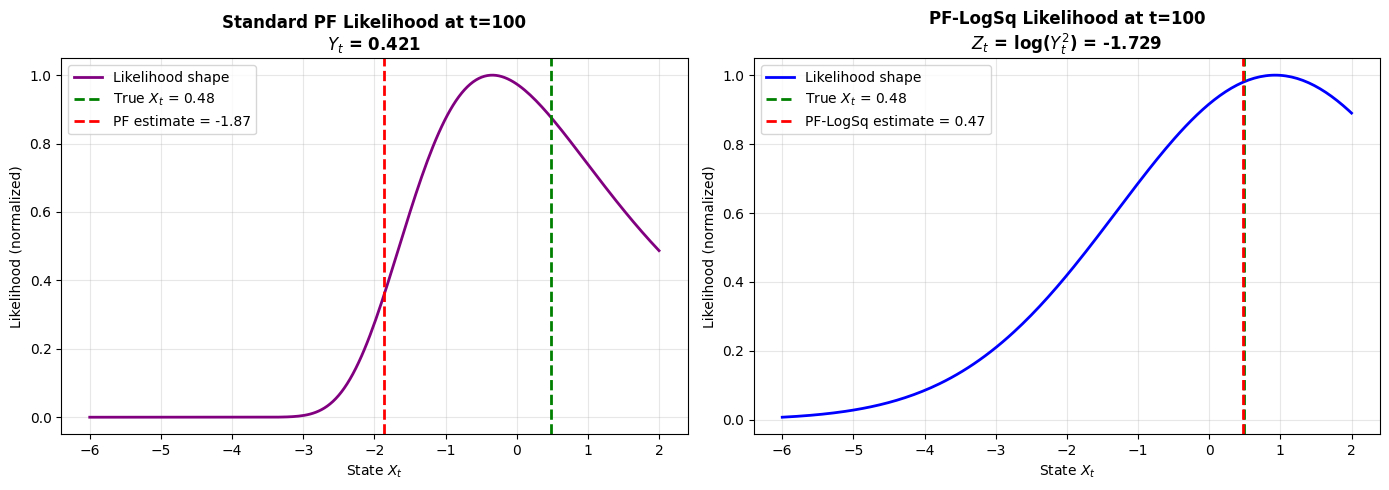


LIKELIHOOD COMPARISON AT t={t_example}:
True state: X_t = 0.4850
Observation: Y_t = 0.4212, Z_t = log(Y_t²) = -1.7294

Standard PF estimate: -1.8663 (error: -2.3513)
PF-LogSq estimate:    0.4712 (error: -0.0138)

Observation:
  - Standard PF uses multiplicative noise → peaked, asymmetric likelihood
  - PF-LogSq uses additive noise → smoother, more symmetric likelihood
  - Log transform makes the problem more 'Gaussian-like'


In [10]:
# ---------------------------------------------------------------
# Diagnostic: Compare observation likelihoods
# ---------------------------------------------------------------

# Let's visualize why the log-squared transformation helps
# by looking at the likelihood shapes

# Pick a time point where we have significant observation
t_example = 100
x_range = np.linspace(-6, 2, 200)
y_obs_ex = Y_obs_flat[t_example]
z_obs_ex = Z_obs[t_example]

# Standard PF likelihood: p(y_t | x_t) ~ N(0, beta^2*exp(x_t))
# This is tricky because the variance depends on x_t
# The likelihood is proportional to: 
# (1/sqrt(beta^2*exp(x_t))) * exp(-y_t²/(2*beta^2*exp(x_t)))

likelihood_standard = np.zeros_like(x_range)
for i, x in enumerate(x_range):
    var = beta_true**2 * np.exp(x)
    likelihood_standard[i] = (1/np.sqrt(2*np.pi*var)) * np.exp(-y_obs_ex**2 / (2*var))

# Log-squared PF likelihood: p(z_t | x_t) ~ N(log(beta^2) + x_t + epsilon_mean, epsilon_var)
likelihood_logsq = np.zeros_like(x_range)
for i, x in enumerate(x_range):
    mean_z = log_beta_sq + x + epsilon_mean
    likelihood_logsq[i] = (1/np.sqrt(2*np.pi*epsilon_var)) * np.exp(-(z_obs_ex - mean_z)**2 / (2*epsilon_var))

# Normalize for comparison
likelihood_standard /= np.max(likelihood_standard)
likelihood_logsq /= np.max(likelihood_logsq)

# True state at this time
x_true_ex = X_true_flat[t_example]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Standard PF likelihood
axes[0].plot(x_range, likelihood_standard, linewidth=2, color='purple', label='Likelihood shape')
axes[0].axvline(x_true_ex, color='green', linestyle='--', linewidth=2, label=f'True $X_t$ = {x_true_ex:.2f}')
axes[0].axvline(est_X_pf[t_example], color='red', linestyle='--', linewidth=2, 
                label=f'PF estimate = {est_X_pf[t_example]:.2f}')
axes[0].set_title(f'Standard PF Likelihood at t={t_example}\n$Y_t$ = {y_obs_ex:.3f}', fontweight='bold')
axes[0].set_xlabel('State $X_t$')
axes[0].set_ylabel('Likelihood (normalized)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Log-squared PF likelihood
axes[1].plot(x_range, likelihood_logsq, linewidth=2, color='blue', label='Likelihood shape')
axes[1].axvline(x_true_ex, color='green', linestyle='--', linewidth=2, label=f'True $X_t$ = {x_true_ex:.2f}')
axes[1].axvline(est_X_log[t_example], color='red', linestyle='--', linewidth=2, 
                label=f'PF-LogSq estimate = {est_X_log[t_example]:.2f}')
axes[1].set_title(f'PF-LogSq Likelihood at t={t_example}\n$Z_t$ = log($Y_t^2$) = {z_obs_ex:.3f}', fontweight='bold')
axes[1].set_xlabel('State $X_t$')
axes[1].set_ylabel('Likelihood (normalized)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("LIKELIHOOD COMPARISON AT t={t_example}:")
print(f"{'='*70}")
print(f"True state: X_t = {x_true_ex:.4f}")
print(f"Observation: Y_t = {y_obs_ex:.4f}, Z_t = log(Y_t²) = {z_obs_ex:.4f}")
print(f"\nStandard PF estimate: {est_X_pf[t_example]:.4f} (error: {est_X_pf[t_example]-x_true_ex:.4f})")
print(f"PF-LogSq estimate:    {est_X_log[t_example]:.4f} (error: {est_X_log[t_example]-x_true_ex:.4f})")
print(f"\nObservation:")
print(f"  - Standard PF uses multiplicative noise → peaked, asymmetric likelihood")
print(f"  - PF-LogSq uses additive noise → smoother, more symmetric likelihood")
print(f"  - Log transform makes the problem more 'Gaussian-like'")
print(f"{'='*70}")